**Key Finding:**

Although the training and validation performance is quite good, the accuracy on the test set is low. There is a lot of literature discussing the imbalanced dataset problem.

When only a limited number of images are provided, overfitting is more likely to occur. Therefore, a considerable amount of labelled data is required for the skin cancer classification task.

* While imbalancing label between train and val was able to handle, regarding to the test set, since we cannot handle the label on that, the low accuracy on the test set is inevitable

reference: Wu Y, Chen B, Zeng A, Pan D, Wang R, Zhao S. Skin Cancer Classification With Deep Learning: A Systematic Review. Front Oncol. 2022 Jul 13;12:893972. doi: 10.3389/fonc.2022.893972. PMID: 35912265; PMCID: PMC9327733

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS

/content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS


In [ ]:
!unzip archive.zip

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [ ]:
!rm archive.zip

rm: cannot remove 'archive.zip': No such file or directory


In [ ]:
ls

 Ass2-Journal.gdoc         Skin_Cancer_Classification
 aug_model.png            'Skin cancer ISIC The International Skin Imaging Collaboration'/
 model_class_balance.png   weights/
 model.png


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings

## Load Data

In [ ]:
def data(dataset_path):
    images = []
    labels = []
    for folder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, folder)
        for subfolder in os.listdir(subfolder_path):
            subfolder_path1 = os.path.join(subfolder_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue
            for image_filename in os.listdir(subfolder_path1):
                if image_filename.endswith(".jpg"):
                    image_path = os.path.join(subfolder_path1, image_filename)
                    images.append(image_path)
                    labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [ ]:
train=data('/content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/Skin cancer ISIC The International Skin Imaging Collaboration')
train.head()

,image,label
0,/content/gdrive/MyDrive/32513 Advanced Data Al...,output
1,/content/gdrive/MyDrive/32513 Advanced Data Al...,output
2,/content/gdrive/MyDrive/32513 Advanced Data Al...,output
3,/content/gdrive/MyDrive/32513 Advanced Data Al...,output
4,/content/gdrive/MyDrive/32513 Advanced Data Al...,output


In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

## Split Dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=rnd_seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=rnd_seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=rnd_seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


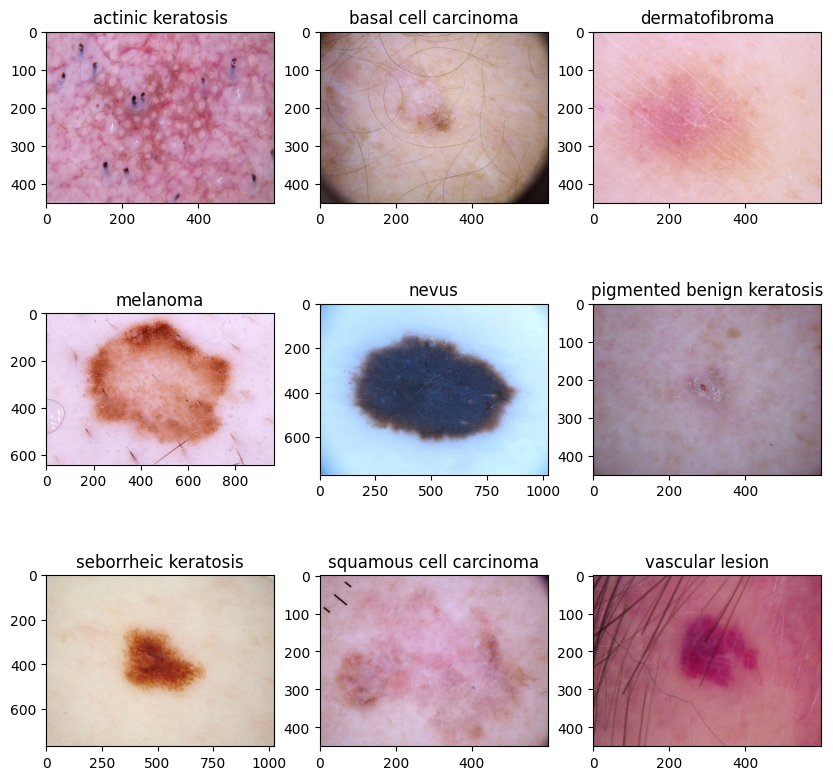

In [ ]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model 1: baseline

In [ ]:
num_classes = 9

# Use the updated method for Rescaling
model = Sequential([
    layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3))
])

model.add(Conv2D(32, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(units=num_classes, activation='softmax'))


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │      13,108,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,686,025 (56.02 MB)

 Trainable params: 14,686,025 (56.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!pip install pydot graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 701.3 kB/s eta 0:00:00


In [ ]:
!apt install python-pydot python-pydot-ng graphviz
# Unfortunately the installed packages tie to Python 2 instead of Python 3
!echo "Check with Python 2"
!python2.7 -c "import pydot"
!echo "Check with Python 3"
!python -c "import pydot"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-pydot
E: Unable to locate package python-pydot-ng
Check with Python 2
/bin/bash: line 1: python2.7: command not found
Check with Python 3


In [ ]:
# Tie pydot to Python 3 using correct pip
!pip -V # tie to Python 3
!dot -V # double check dot command is available
!pip install pydot pydot-ng
!echo "Check again with Python 3"
!python -c "import pydot"

pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
dot - graphviz version 2.43.0 (0)
Check again with Python 3


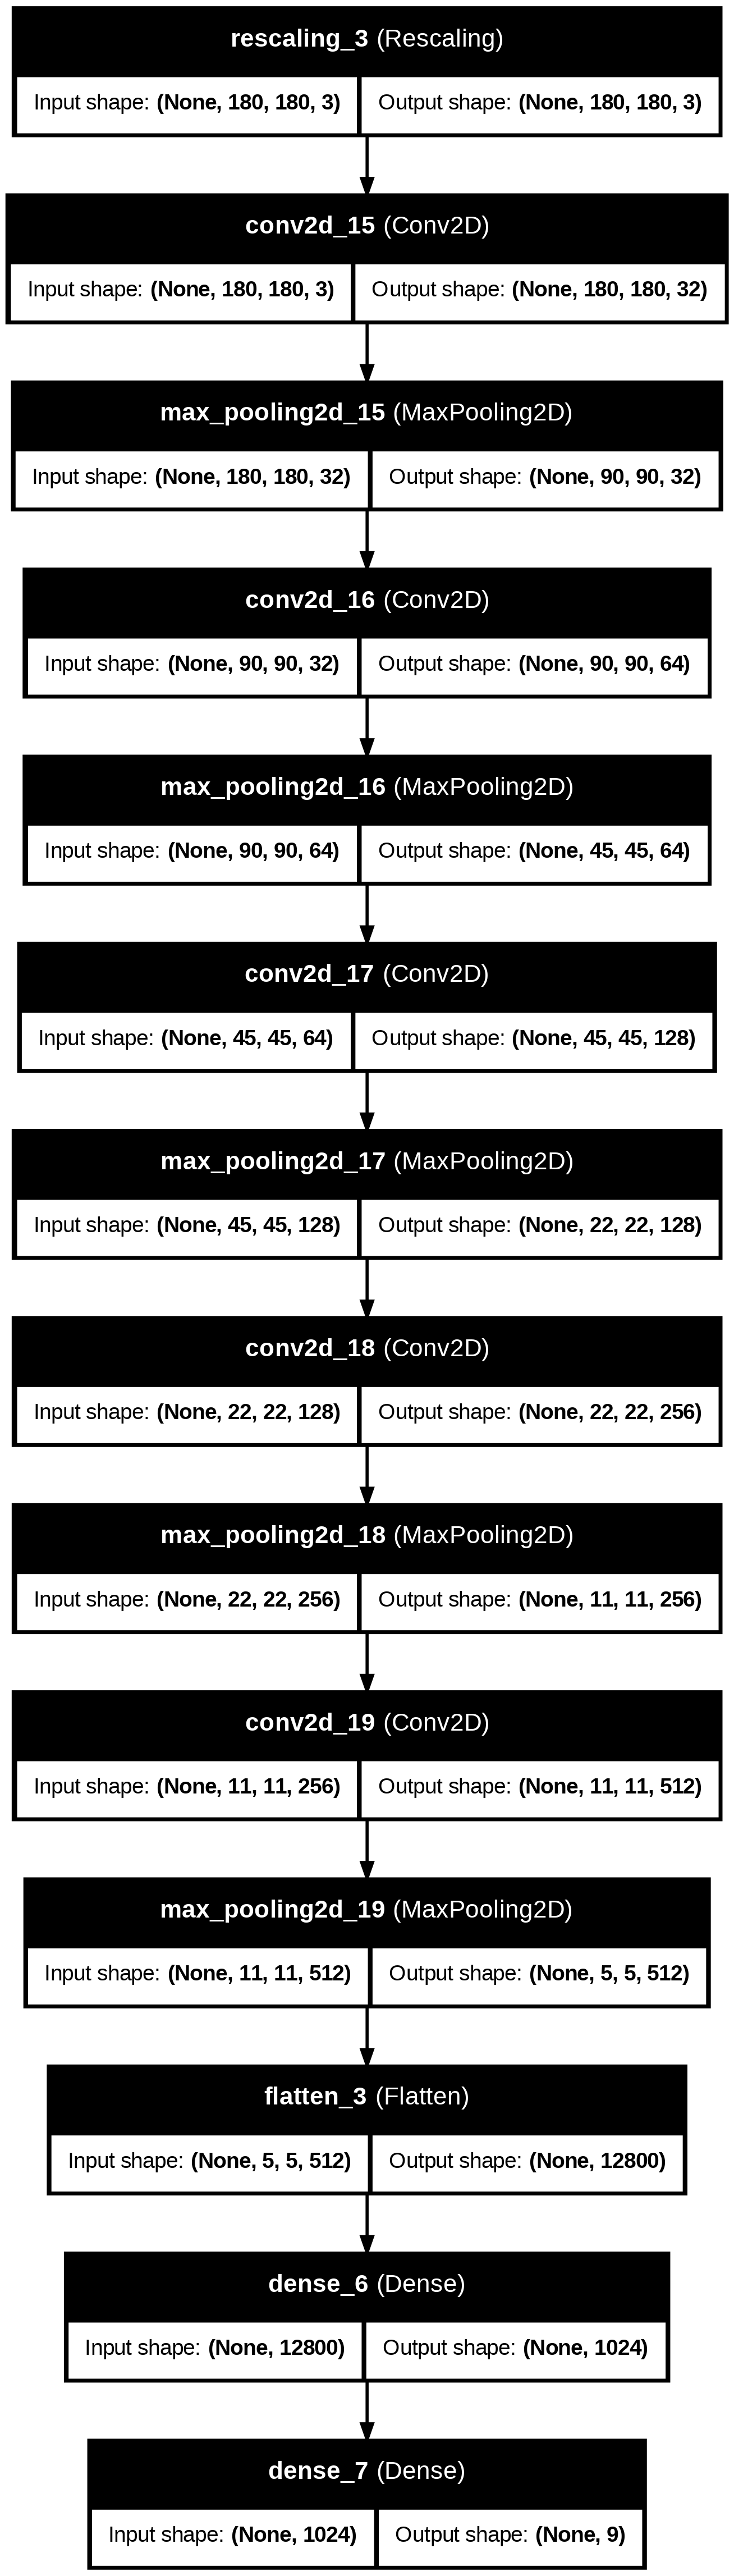

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the checkpoint callback
checkpoint_path = "/content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/base_model_epoch_{epoch:02d}-val_accuracy_{val_accuracy:.2f}.h5"  # Save models with the epoch number in filename
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - ETA: 0s - loss: 2.0504 - accuracy: 0.2081
Epoch 1: saving model to /content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/base_model_epoch_01-val_accuracy_0.32.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 37s 467ms/step - loss: 2.0504 - accuracy: 0.2081 - val_loss: 1.8622 - val_accuracy: 0.3244
Epoch 2/25
56/56 [==============================] - ETA: 0s - loss: 1.8560 - accuracy: 0.3064
Epoch 2: saving model to /content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/base_model_epoch_02-val_accuracy_0.35.h5
56/56 [==============================] - 19s 346ms/step - loss: 1.8560 - accuracy: 0.3064 - val_loss: 1.7464 - val_accuracy: 0.3490
Epoch 3/25
56/56 [==============================] - ETA: 0s - loss: 1.7064 - accuracy: 0.3705
Epoch 3: saving model to /content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/base_model_epoch_03-val_accuracy_0.44.h5
56/56 [==============================] - 19s 340ms/step - loss: 1.7064 - accuracy: 0.3705 - val_loss: 1.6210 - val_accuracy: 0.4385
Epoch 4/25
56/56 [==============================] - ETA: 0s - loss: 1.6097 - accuracy: 0.4202
Epoch 4: saving model to /content/gdrive/MyDrive/32513 Adv

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)

4/4 [==============================] - 2s 55ms/step - loss: 5.2550 - accuracy: 0.2642
Test accuracy: 0.2641509473323822


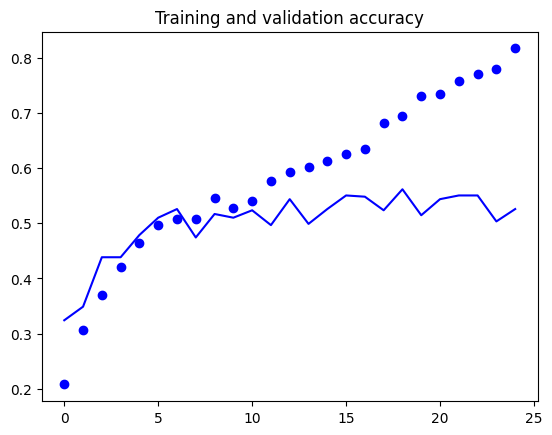

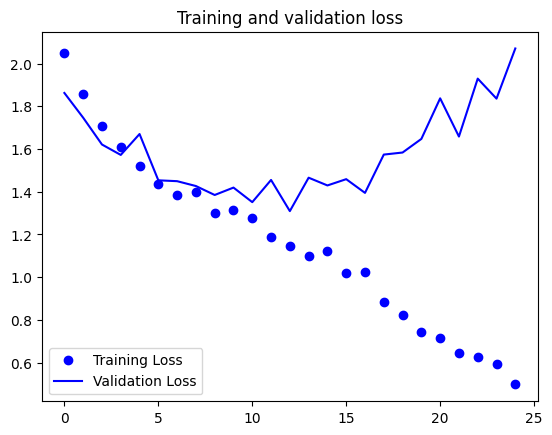

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(epochs)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Extracting training and validation loss and accuracies
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Since we train for 100 epochs, we take the last values for train and validation
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

# Creating a DataFrame
base_performance_df = pd.DataFrame({
    'Set': ['Train', 'Validation', 'Test'],
    'Loss': [final_train_loss, final_val_loss, test_loss],
    'Accuracy': [final_train_acc, final_val_acc, test_acc]
})

# Display the table
print(base_performance_df)

          Set      Loss  Accuracy
0       Train  0.498093  0.816406
1  Validation  2.070392  0.525727
2        Test  5.255012  0.264151


4/4 [==============================] - 1s 51ms/step


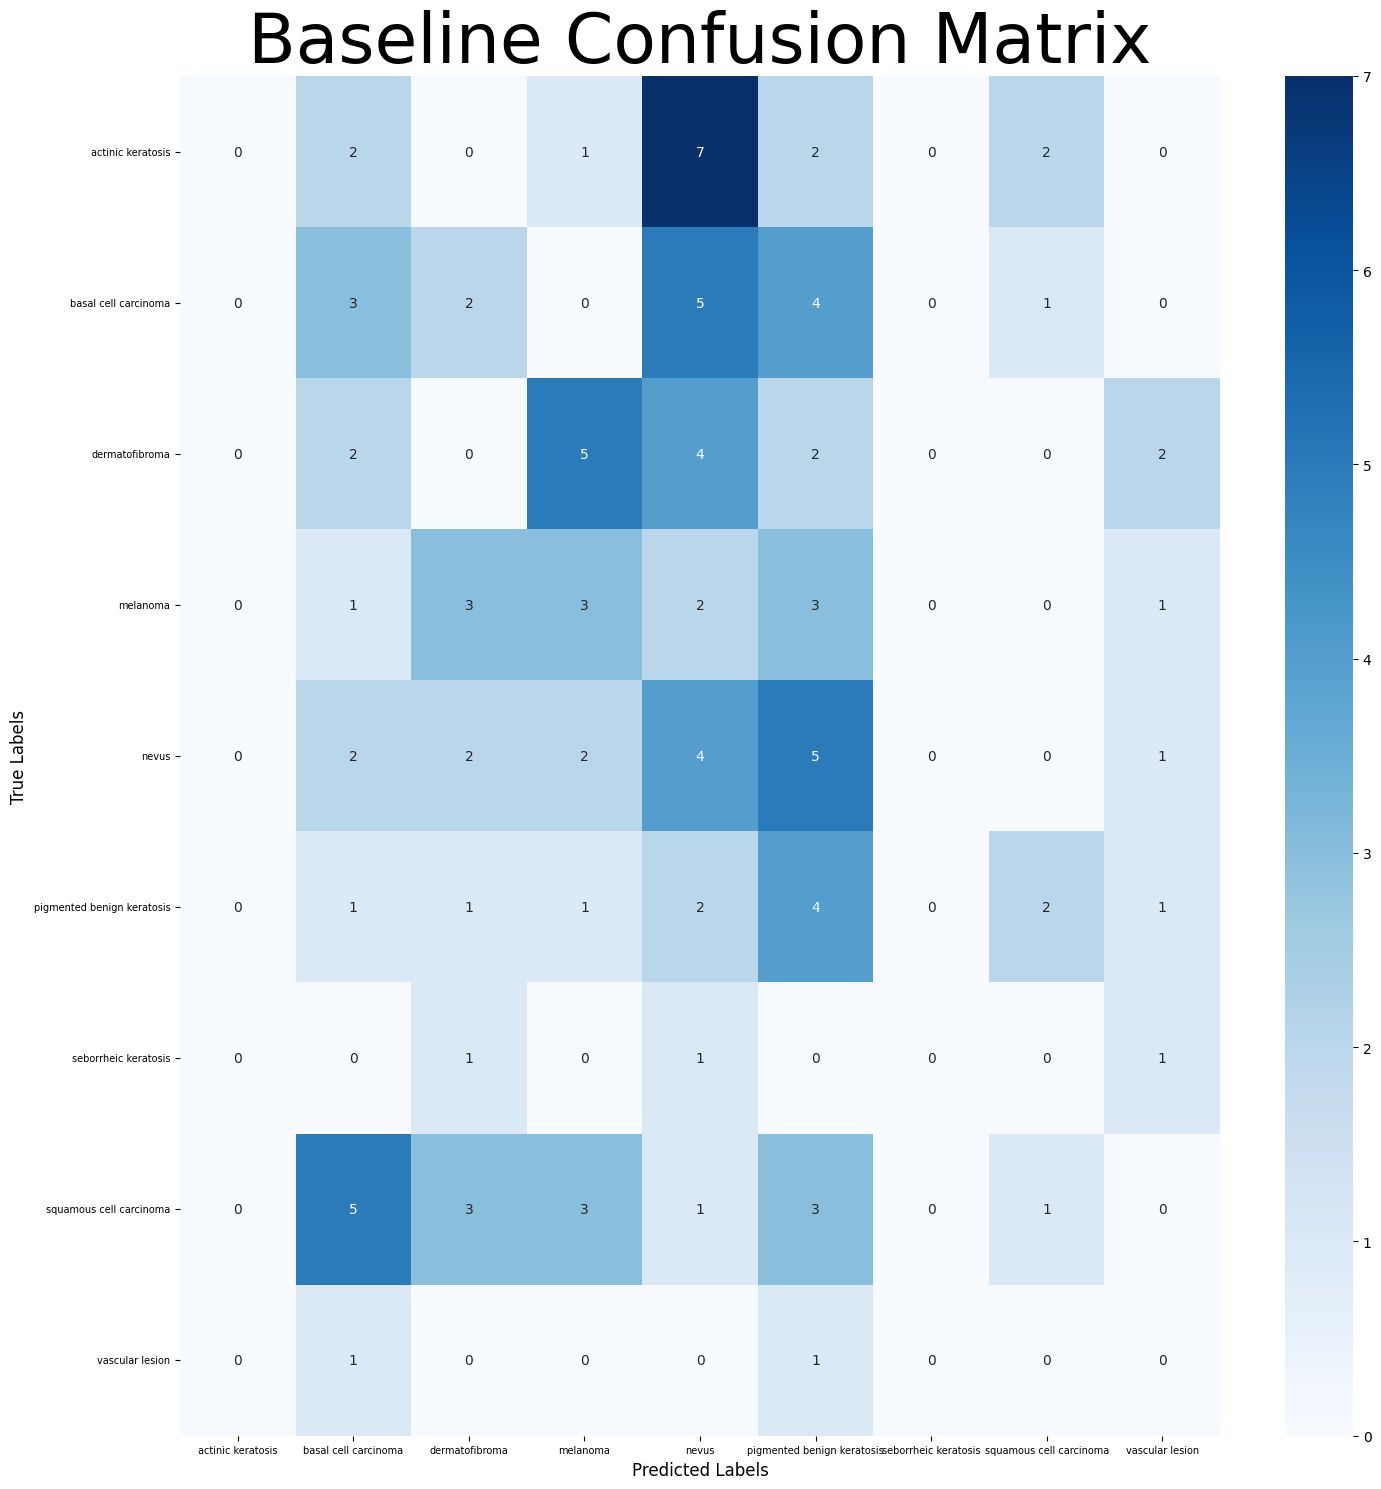

In [ ]:
# Extract true labels from the test dataset
model = load_model('/content/gdrive/MyDrive/42028/ass2/Image_Classification/weights/base_model_epoch_54-val_accuracy_0.96.h5')


true_classes = []
for images, labels in test_ds:
    true_classes.extend(labels.numpy())  # Assuming labels are integers, directly convert them to numpy

# Convert the list to a numpy array
true_classes = np.array(true_classes)

# Predict the labels of the test images
predictions = model.predict(test_ds)

# Convert predictions from probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Baseline Confusion Matrix', fontsize=50)
plt.ylabel('True Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

# Plot adjustment
# Use the list of class names directly if class_labels is a list
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=360, fontsize=7)  # Offset by 0.5 to center the labels and adjust font size
plt.yticks(tick_marks + 0.5, class_names, rotation=360, fontsize=7)  # Adjust font size

plt.tight_layout()
plt.show()


**Findings**

The model is overfitting because we can see the difference in accuracy in training data & accuracy in the validation data that is almost 20%.

The training accuracy is just around 70-75% with 25 epochos and the model is yet to learn the many features.

data imbalance might be causing the bais to the model.

## Model 2 : Data Augumentation with drop out layer.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


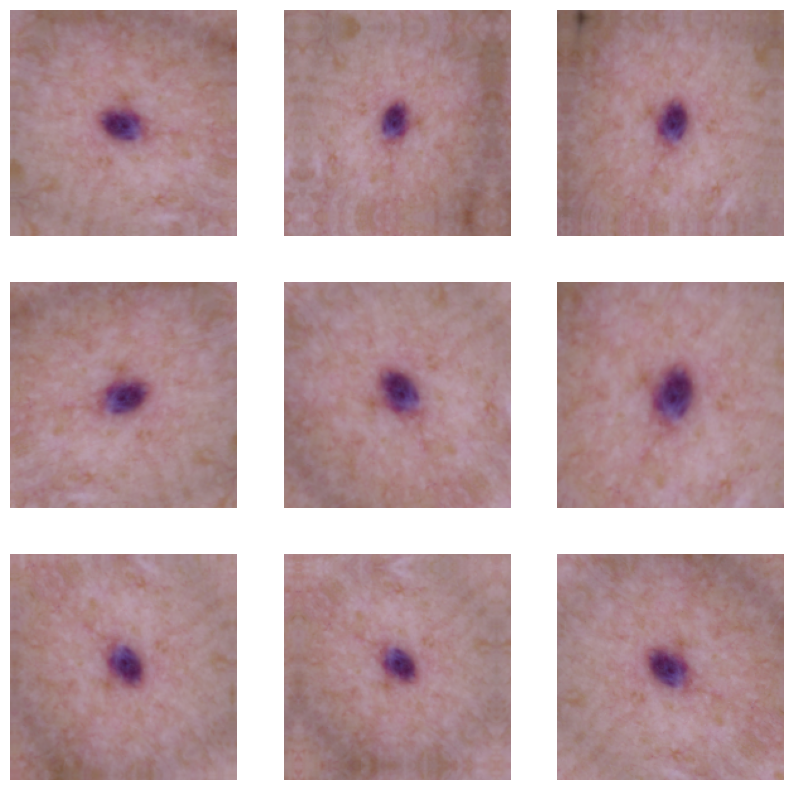

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Rescaling
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

num_classes = 9
img_height, img_width = 180, 180  # Example image dimensions

model = Sequential()

# Data augmentation layer (assuming this is already defined)
model.add(data_augmentation)

# Input Rescaling layer with input shape defined
model.add(Rescaling(1.0/255, input_shape=(img_height, img_width, 3)))

# Adding Conv2D, MaxPool2D, Dropout layers
model.add(Conv2D(32, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

# Fully connected layers
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(units=num_classes, activation='softmax'))

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (1, 180, 180, 32)           │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (1, 90, 90, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (1, 90, 90, 64)             │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (1, 45, 45, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (1, 45, 45, 128)            │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (1, 22, 22, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (1, 22, 22, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (1, 22, 22, 256)            │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (1, 11, 11, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (1, 11, 11, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (1, 11, 11, 512)            │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (1, 5, 5, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (1, 5, 5, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (1, 12800)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (1, 1024)                   │      13,108,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (1, 9)                      │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,686,025 (56.02 MB)

 Trainable params: 14,686,025 (56.02 MB)

 Non-trainable params: 0 (0.00 B)

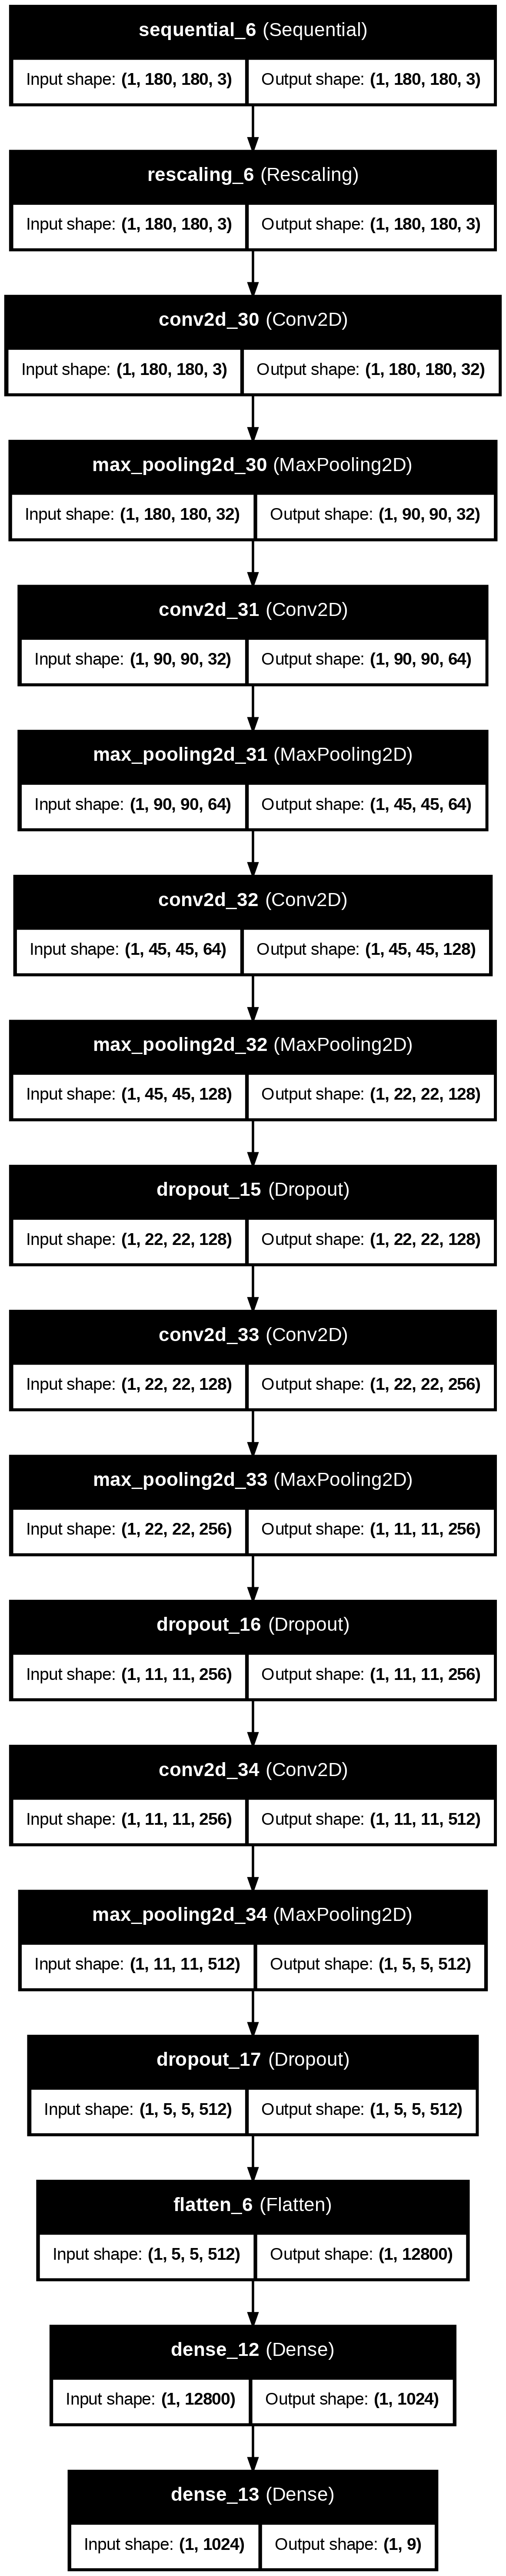

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the checkpoint callback
checkpoint_path = "/content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/aug_model_epoch_{epoch:02d}-val_accuracy_{val_accuracy:.2f}.keras"  # Save models with the epoch number in filename
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2254 - loss: 2.7659
Epoch 1: val_accuracy improved from -inf to 0.19239, saving model to /content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/aug_model_epoch_01-val_accuracy_0.19.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 311s 6s/step - accuracy: 0.2251 - loss: 2.7569 - val_accuracy: 0.1924 - val_loss: 2.0317
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2023 - loss: 2.0155
Epoch 2: val_accuracy improved from 0.19239 to 0.27740, saving model to /content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/aug_model_epoch_02-val_accuracy_0.28.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.2030 - loss: 2.0151 - val_accuracy: 0.2774 - val_loss: 1.8370
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2763 - loss: 1.9050
Epoch 3: val_accuracy improved from 0.27740 to 0.36242, saving model to /content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/aug_model_epoch_03-val_accuracy_0

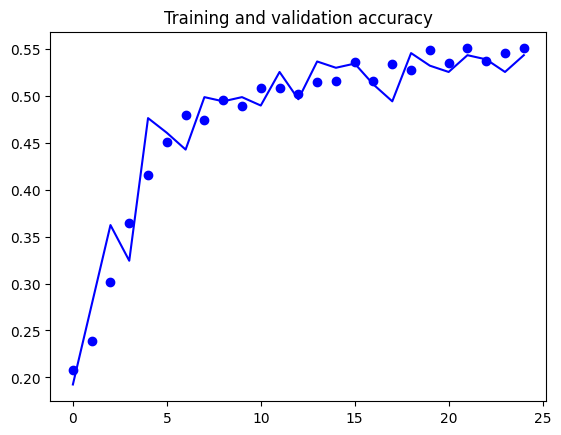

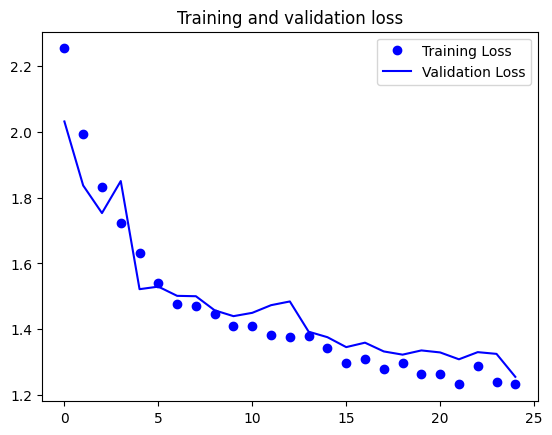

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(epochs)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Extracting training and validation loss and accuracies
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Since we train for 100 epochs, we take the last values for train and validation
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

# Creating a DataFrame
base_performance_df = pd.DataFrame({
    'Set': ['Train', 'Validation', 'Test'],
    'Loss': [final_train_loss, final_val_loss, test_loss],
    'Accuracy': [final_train_acc, final_val_acc, test_acc]
})

# Display the table
print(base_performance_df)

          Set      Loss  Accuracy
0       Train  1.235060  0.550781
1  Validation  1.255448  0.543624
2        Test  2.055428  0.349057


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


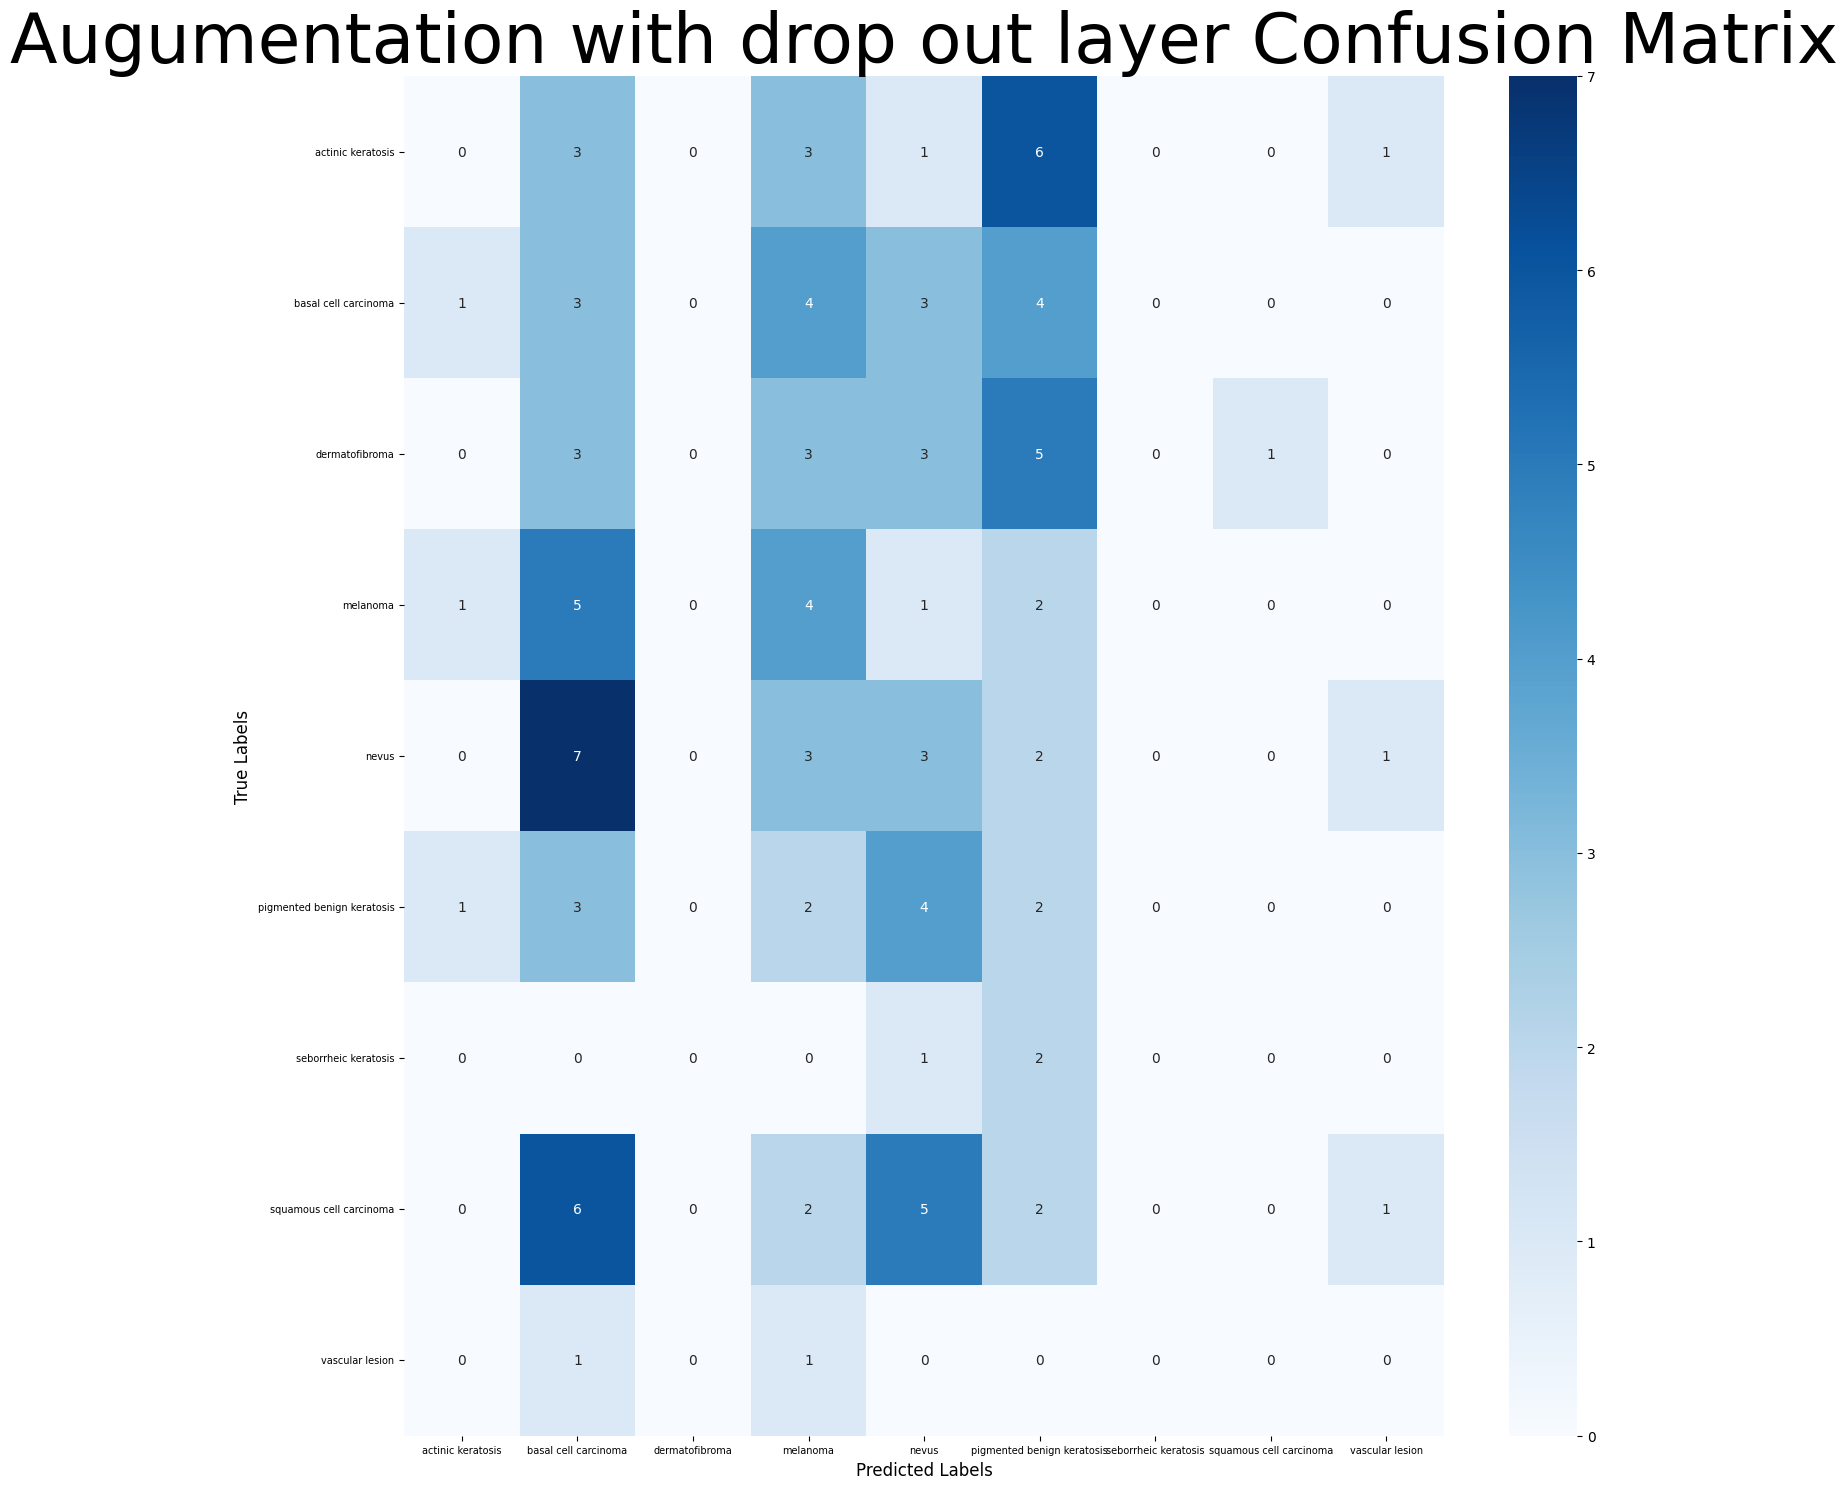

In [ ]:
from tensorflow.keras.models import load_model # Import the load_model function from tensorflow.keras.models

# Extract true labels from the test dataset
model = load_model('/content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/aug_model_epoch_19-val_accuracy_0.55.keras')



true_classes = []
for images, labels in test_ds:
    true_classes.extend(labels.numpy())  # Assuming labels are integers, directly convert them to numpy

# Convert the list to a numpy array
true_classes = np.array(true_classes)

# Predict the labels of the test images
predictions = model.predict(test_ds)

# Convert predictions from probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Augumentation with drop out layer Confusion Matrix', fontsize=50)
plt.ylabel('True Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

# Plot adjustment
# Use the list of class names directly if class_labels is a list
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=360, fontsize=7)  # Offset by 0.5 to center the labels and adjust font size
plt.yticks(tick_marks + 0.5, class_names, rotation=360, fontsize=7)  # Adjust font size

plt.tight_layout()
plt.show()


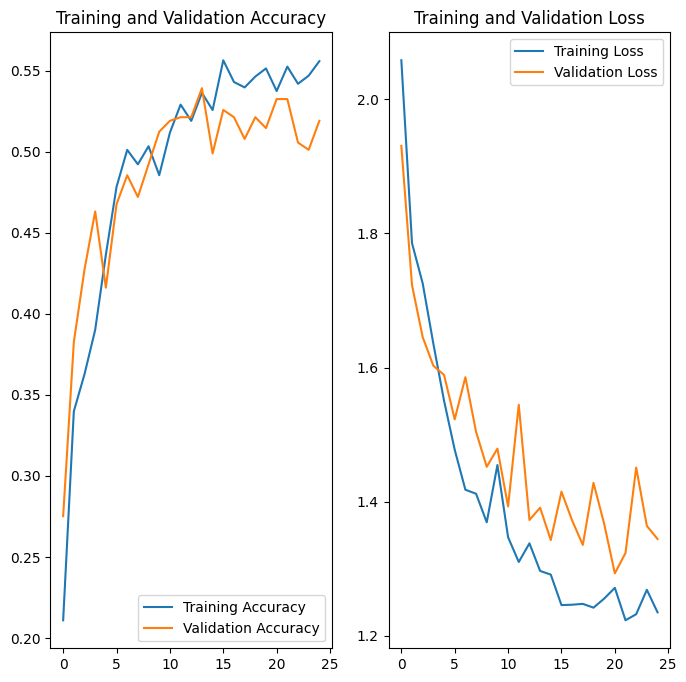

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**

With data agumenatation and drop layer, the overfitting of the model is adressed to great extend. Earlier the train and validation accuracy difference was nearly 20%, with latest approach it's reduced to 2-3%.

The accuracy of the model is compromised heavily and decreased by fair bit from previous venilla model.

Considering above 2 points, there is still a scope of lot of improvement of the model.



## Analysing the class imbalance of the data¶

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

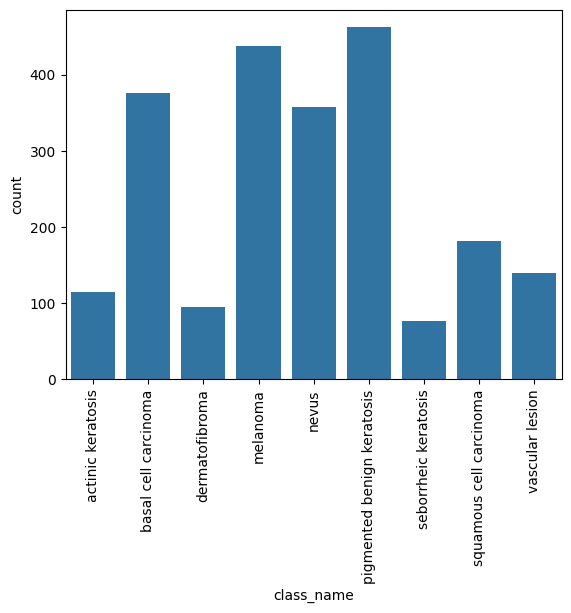

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

**Findings**

Data is hevily imbalance and hence due to that results and predictions will be baised.

Augmentor : Class balance
Using Augmentor (https://augmentor.readthedocs.io/en/master/) to create the equal distribution of the class.

In [ ]:
!pip install Augmentor

In [ ]:
path_to_training_dataset = '/content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/Skin cancer ISIC The International Skin Imaging Collaboration/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

In [ ]:
output_dir = pathlib.Path('/content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/Skin cancer ISIC The International Skin Imaging Collaboration/data')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

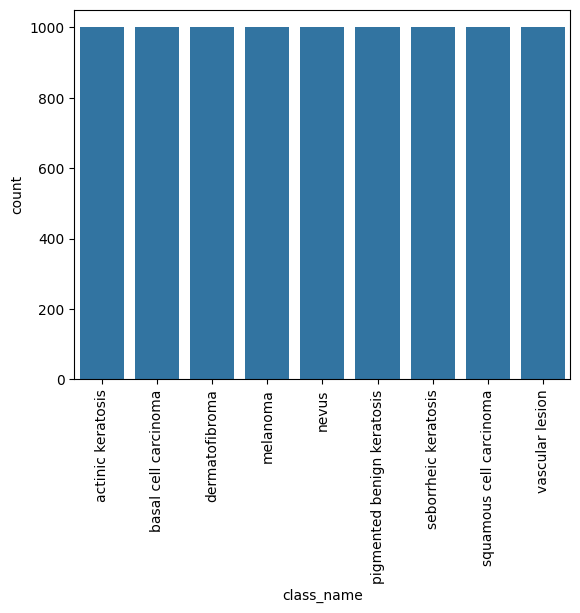

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

## Model 3 : Model with Class balance data.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [ ]:
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
num_classes = 9
model = Sequential([layers.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the checkpoint callback
checkpoint_path = "/content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/class_balance_model_epoch_{epoch:02d}-val_accuracy_{val_accuracy:.2f}.keras"  # Save models with the epoch number in filename
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


225/225 [==============================] - ETA: 0s - loss: 1.9318 - accuracy: 0.2439
Epoch 1: val_accuracy improved from -inf to 0.31000, saving model to /content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/class_balance_model_epoch_01-val_accuracy_0.31.keras
225/225 [==============================] - 105s 403ms/step - loss: 1.9318 - accuracy: 0.2439 - val_loss: 1.7167 - val_accuracy: 0.3100
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: 1.5337 - accuracy: 0.3872
Epoch 2: val_accuracy improved from 0.31000 to 0.40056, saving model to /content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/class_balance_model_epoch_02-val_accuracy_0.40.keras
225/225 [==============================] - 80s 352ms/step - loss: 1.5337 - accuracy: 0.3872 - val_loss: 1.5521 - val_accuracy: 0.4006
Epoch 3/25
225/225 [==============================] - ETA: 0s - loss: 1.4352 - accuracy: 0.4361
Epoch 3: val_accuracy did not improve from 0.40056
225/225 [===============

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)

4/4 [==============================] - 2s 51ms/step - loss: 4.6676 - accuracy: 0.3585
Test accuracy: 0.35849055647850037


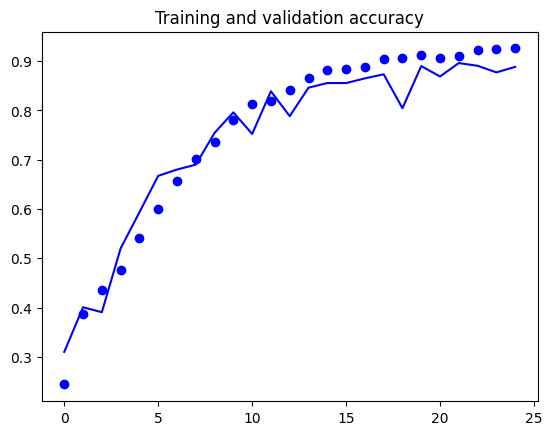

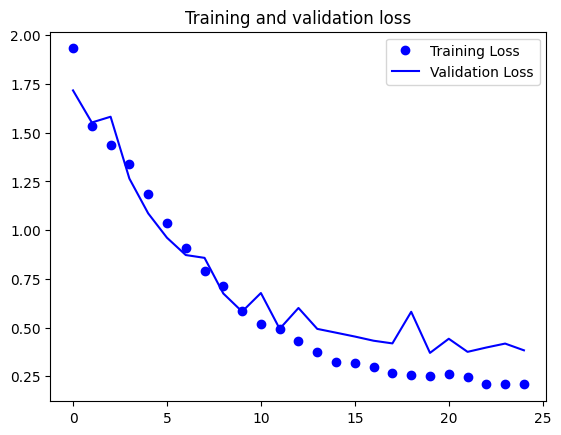

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(epochs)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Extracting training and validation loss and accuracies
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Since we train for 100 epochs, we take the last values for train and validation
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

# Creating a DataFrame
base_performance_df = pd.DataFrame({
    'Set': ['Train', 'Validation', 'Test'],
    'Loss': [final_train_loss, final_val_loss, test_loss],
    'Accuracy': [final_train_acc, final_val_acc, test_acc]
})

# Display the table
print(base_performance_df)

          Set      Loss  Accuracy
0       Train  0.208261  0.925694
1  Validation  0.383487  0.888333
2        Test  4.667648  0.358491


4/4 [==============================] - 1s 51ms/step


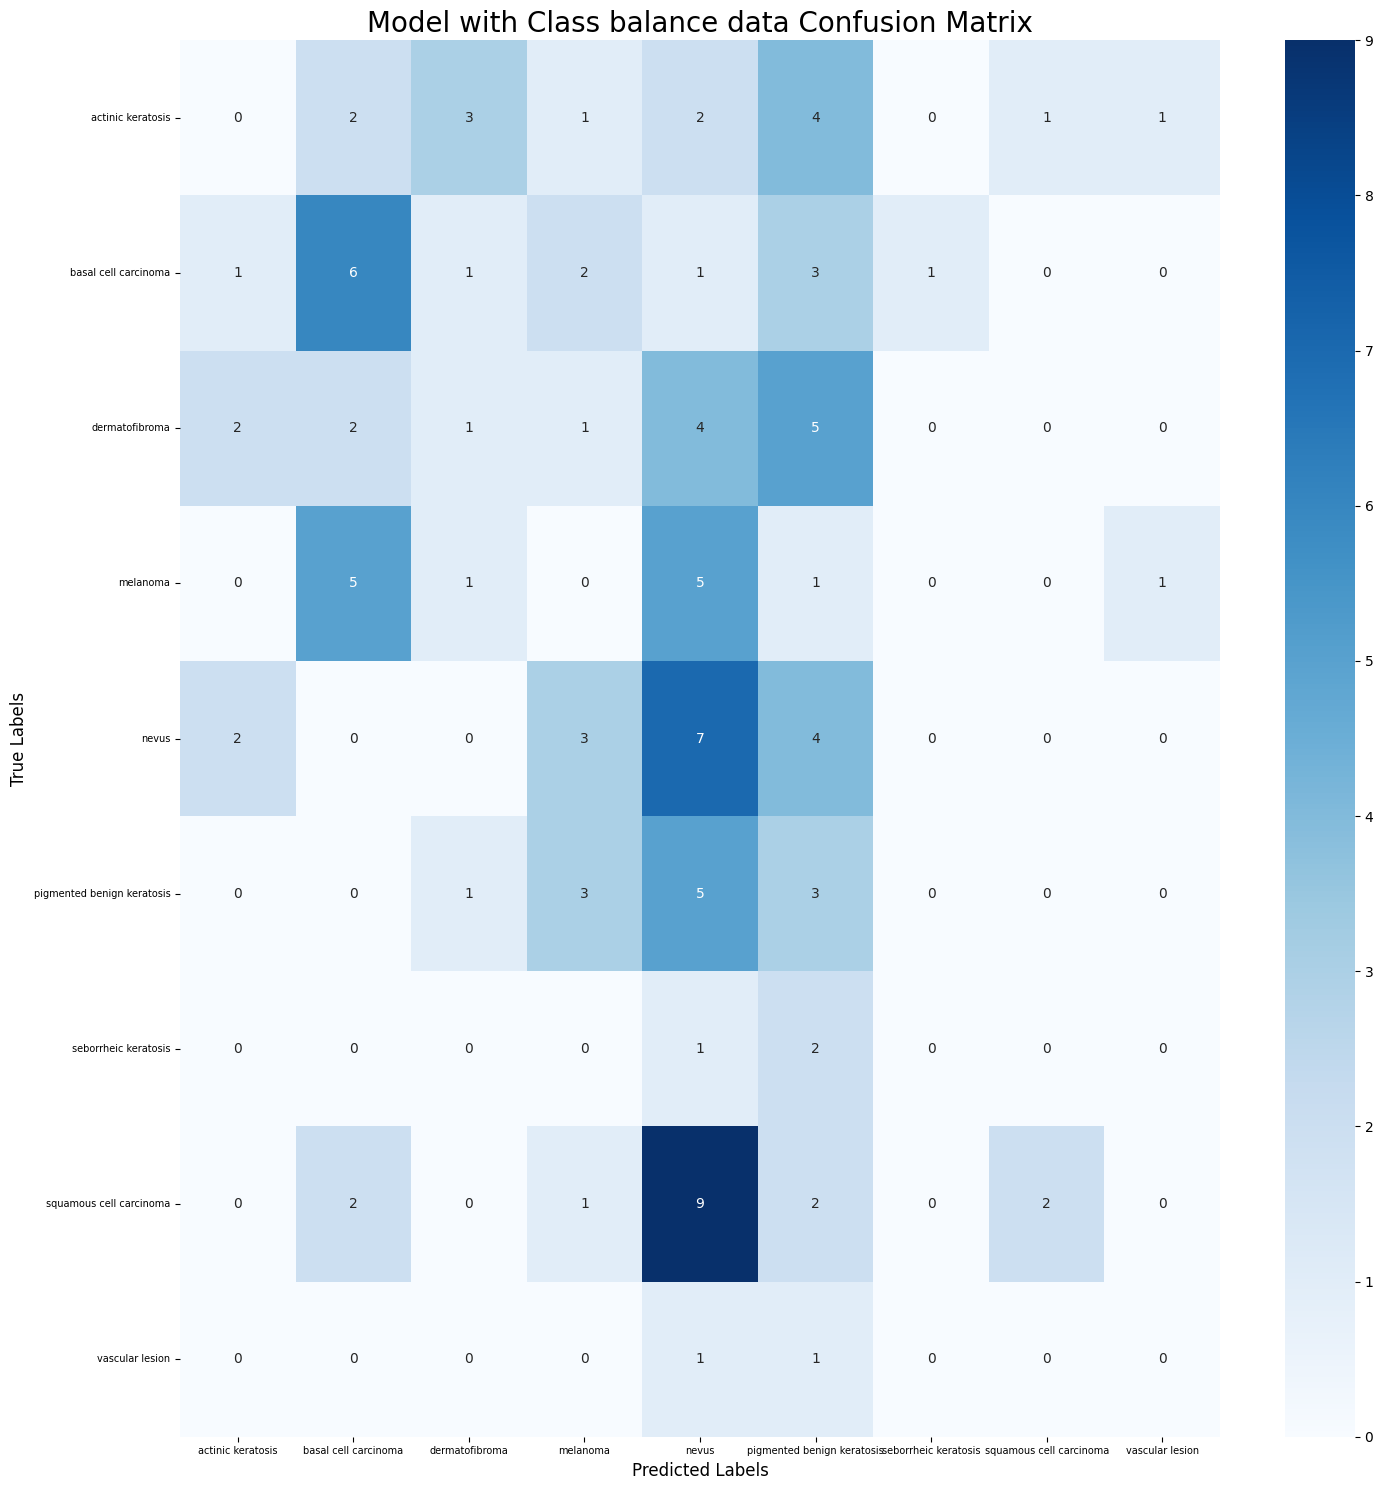

In [ ]:
# Extract true labels from the test dataset
true_classes = []
for images, labels in test_ds:
    true_classes.extend(labels.numpy())  # Assuming labels are integers, directly convert them to numpy

# Convert the list to a numpy array
true_classes = np.array(true_classes)

# Predict the labels of the test images
predictions = model.predict(test_ds)

# Convert predictions from probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Model with Class balance data Confusion Matrix', fontsize=20)
plt.ylabel('True Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

# Plot adjustment
# Use the list of class names directly if class_labels is a list
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=360, fontsize=7)  # Offset by 0.5 to center the labels and adjust font size
plt.yticks(tick_marks + 0.5, class_names, rotation=360, fontsize=7)  # Adjust font size

plt.tight_layout()
plt.show()


*  augmentation + class balance in third model

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Rescaling
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

num_classes = 9
img_height, img_width = 180, 180  # Example image dimensions

model = Sequential()

# Data augmentation layer (assuming this is already defined)
model.add(data_augmentation)

# Input Rescaling layer with input shape defined
model.add(Rescaling(1.0/255, input_shape=(img_height, img_width, 3)))

# Adding Conv2D, MaxPool2D, Dropout layers
model.add(Conv2D(32, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

# Fully connected layers
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(units=num_classes, activation='softmax'))

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the checkpoint callback
checkpoint_path = "/content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/aug_class_balance_model_epoch_{epoch:02d}-val_accuracy_{val_accuracy:.2f}.keras"  # Save models with the epoch number in filename
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


225/225 [==============================] - ETA: 0s - loss: 1.9352 - accuracy: 0.2271
Epoch 1: val_accuracy improved from -inf to 0.19222, saving model to /content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/aug_class_balance_model_epoch_01-val_accuracy_0.19.keras
225/225 [==============================] - 105s 403ms/step - loss: 1.9352 - accuracy: 0.2271 - val_loss: 1.9909 - val_accuracy: 0.1922
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: 1.6627 - accuracy: 0.3374
Epoch 2: val_accuracy improved from 0.19222 to 0.38333, saving model to /content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/weights/aug_class_balance_model_epoch_02-val_accuracy_0.38.keras
225/225 [==============================] - 92s 409ms/step - loss: 1.6627 - accuracy: 0.3374 - val_loss: 1.6317 - val_accuracy: 0.3833
Epoch 3/25
225/225 [==============================] - ETA: 0s - loss: 1.4772 - accuracy: 0.4196
Epoch 3: val_accuracy improved from 0.38333 to 0.40889, saving mode

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)

4/4 [==============================] - 2s 76ms/step - loss: 2.6969 - accuracy: 0.4528
Test accuracy: 0.4528301954269409


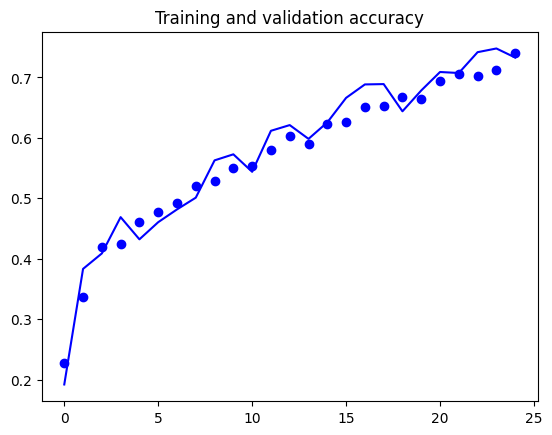

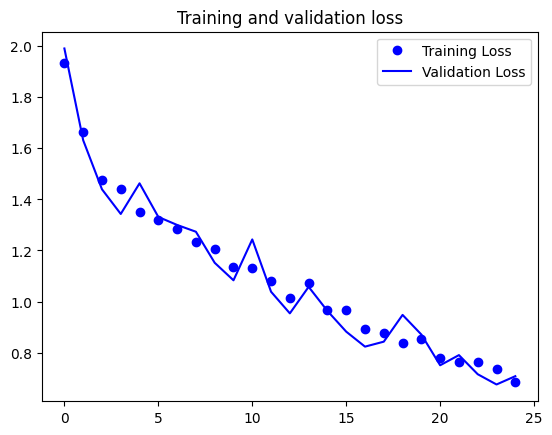

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(epochs)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Extracting training and validation loss and accuracies
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Since we train for 100 epochs, we take the last values for train and validation
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

# Creating a DataFrame
base_performance_df = pd.DataFrame({
    'Set': ['Train', 'Validation', 'Test'],
    'Loss': [final_train_loss, final_val_loss, test_loss],
    'Accuracy': [final_train_acc, final_val_acc, test_acc]
})

# Display the table
print(base_performance_df)

          Set      Loss  Accuracy
0       Train  0.683974  0.740833
1  Validation  0.707907  0.732778
2        Test  2.696934  0.452830


4/4 [==============================] - 1s 52ms/step


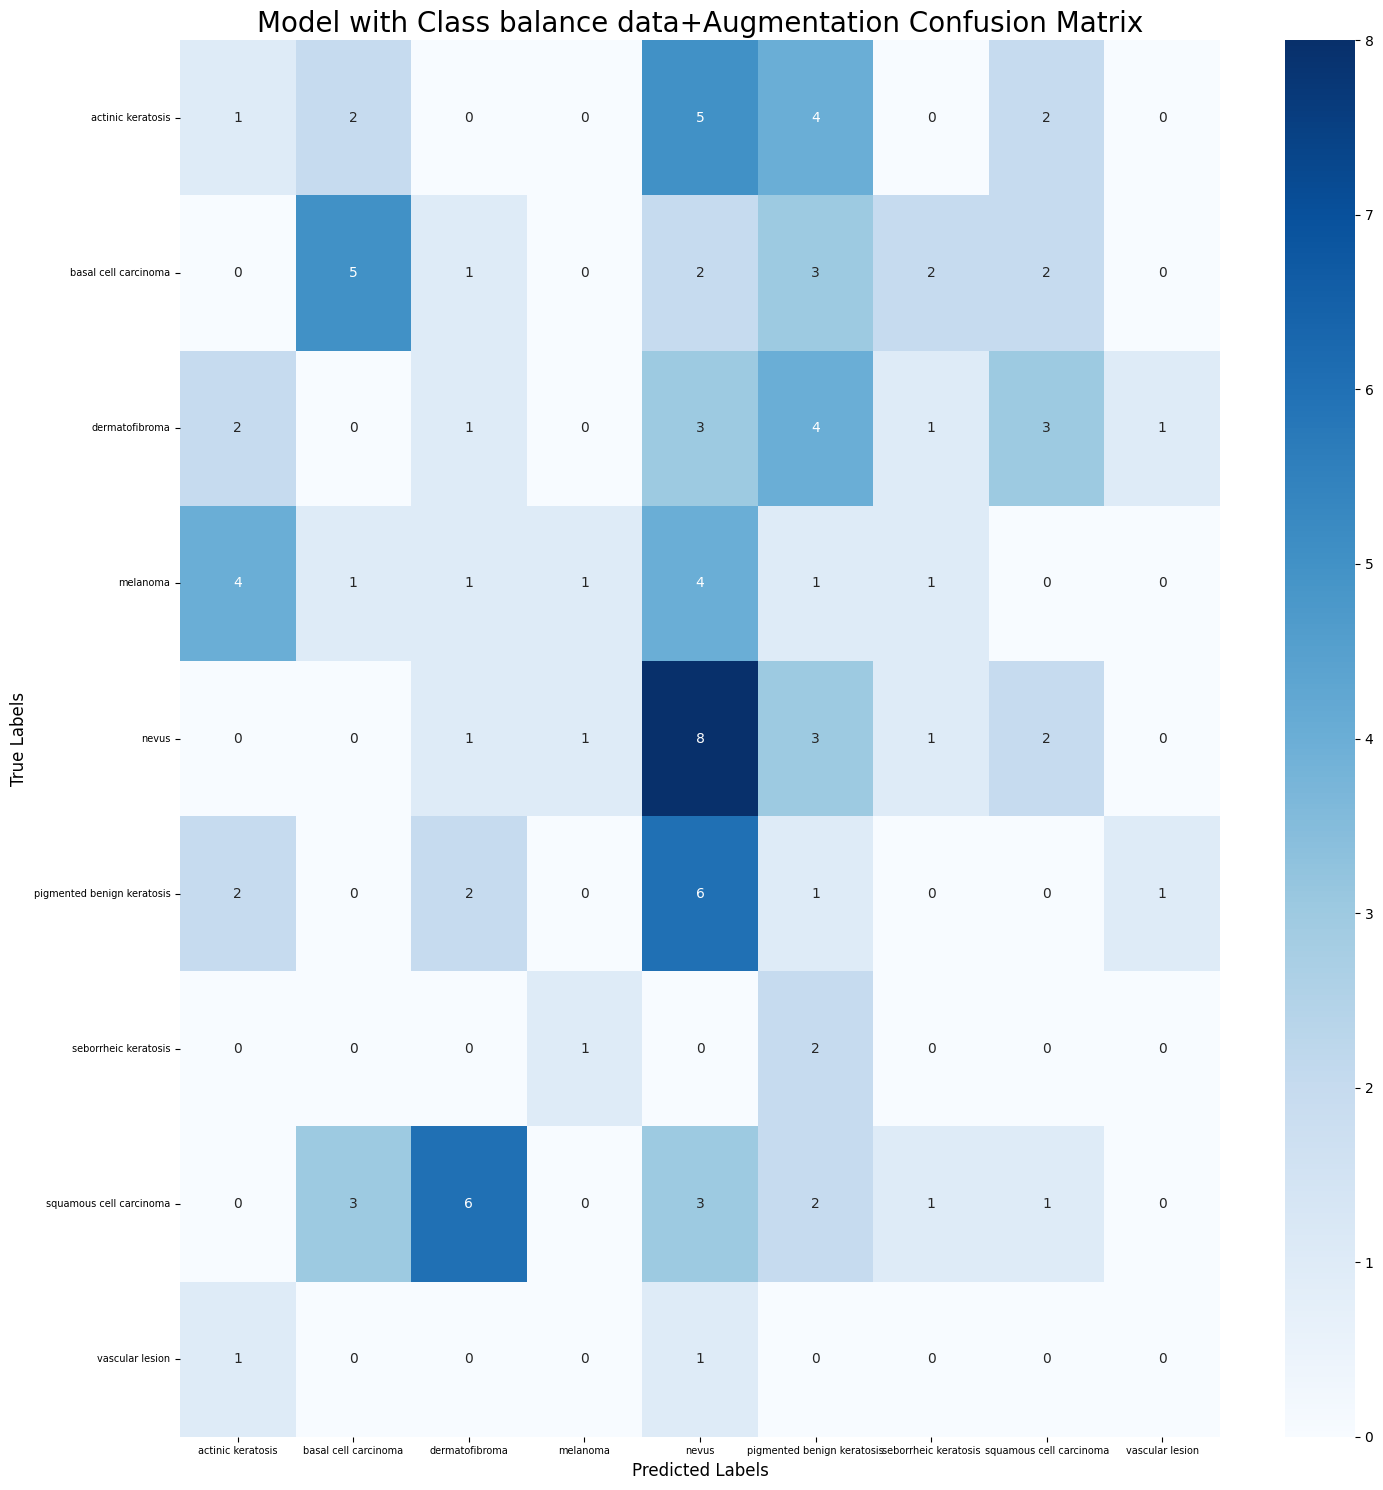

In [ ]:
# Extract true labels from the test dataset
true_classes = []
for images, labels in test_ds:
    true_classes.extend(labels.numpy())  # Assuming labels are integers, directly convert them to numpy

# Convert the list to a numpy array
true_classes = np.array(true_classes)

# Predict the labels of the test images
predictions = model.predict(test_ds)

# Convert predictions from probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Model with Class balance data+Augmentation Confusion Matrix', fontsize=20)
plt.ylabel('True Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

# Plot adjustment
# Use the list of class names directly if class_labels is a list
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=360, fontsize=7)  # Offset by 0.5 to center the labels and adjust font size
plt.yticks(tick_marks + 0.5, class_names, rotation=360, fontsize=7)  # Adjust font size

plt.tight_layout()
plt.show()


## Evaluation

In [ ]:
#Create a file to save models
top_model_weights_path = '/content/gdrive/MyDrive/32513 Advanced Data Algorithm/ASS/cnn_fc_model.h5'
model.save_weights(top_model_weights_path)

In [ ]:
(train_eval_loss, train_eval_accuracy) = model.evaluate(train_ds, batch_size=batch_size, \
                                            verbose=1)

225/225 [==============================] - 18s 77ms/step - loss: 0.1734 - accuracy: 0.9364


In [ ]:
(val_eval_loss, val_eval_accuracy) = model.evaluate(val_ds, batch_size=batch_size, \
                                            verbose=1)

57/57 [==============================] - 5s 75ms/step - loss: 0.3974 - accuracy: 0.8861


In [ ]:
(test_eval_loss, test_eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size, \
                                            verbose=1)

4/4 [==============================] - 3s 45ms/step - loss: 4.6656 - accuracy: 0.3774


In [ ]:
print("[INFO] accuracy: {:.2f}%".format(train_eval_accuracy * 100))
print("[INFO] Loss: {}".format(train_eval_loss))
print("[INFO] accuracy: {:.2f}%".format(val_eval_accuracy * 100))
print("[INFO] Loss: {}".format(val_eval_loss))
print("[INFO] accuracy: {:.2f}%".format(test_eval_accuracy * 100))
print("[INFO] Loss: {}".format(test_eval_loss))

[INFO] accuracy: 93.64%
[INFO] Loss: 0.17343217134475708
[INFO] accuracy: 88.61%
[INFO] Loss: 0.3974275588989258
[INFO] accuracy: 37.74%
[INFO] Loss: 4.665642738342285


*Reference: https://www.kaggle.com/code/sharanharsoor/skin-cancer-detection/notebook*